# 1. 고객 유치(Acqusition) 분석

## 1) MAU 분석

월별 활성화 이용자 수(MAU)를 구해보자.
1) 다른 기기로 접속했더라도 user-id 값 같다면 같은 사용자로 통합
2) 활성 사용자: 기기 기준(웹과 앱)으로 구분 (웹과 앱 접속은 다른 사용자로 계산)
웹: 브라우저 인스턴스 식별 위해 쿠키에 심어둔 식별자 기준
앱: 앱을 설치할 때마다 생성하는 식별자 기준
식별자: fullVisitorId


fullvisitorid: 쿠리를 기반으로 사용자를 추적함

* 사용자가 브라우저나 디바이스를 변경해 사이트 방문시 새로운 fullvisitorid 생성 가능. 쿠키는 브라우저/디바이스마다 별도로 저장됨

* 사용자가 쿠키 삭제할 시 새로운 fullvisitorid 생성

* google analytics의 쿠키에는 만료 기간이 설정되어 있음. 사용자가 2년 동안 사이트를 방문하지 않고, 그 후에 사이트를 다시 방문한다면 새로운 fullvisitorid가 할당

2016년 8월의 활성화 이용자 수 

In [ ]:
query = f"""
SELECT COUNT(distinct fullVisitorId) as active_users, COUNT(device.deviceCategory) as device_number, COUNT(device.browser) as browser_number
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'
GROUP BY fullVisitorId
"""

result = client.query(query).result().to_dataframe()

20160801 ~ 20170731까지의 MAU line graph

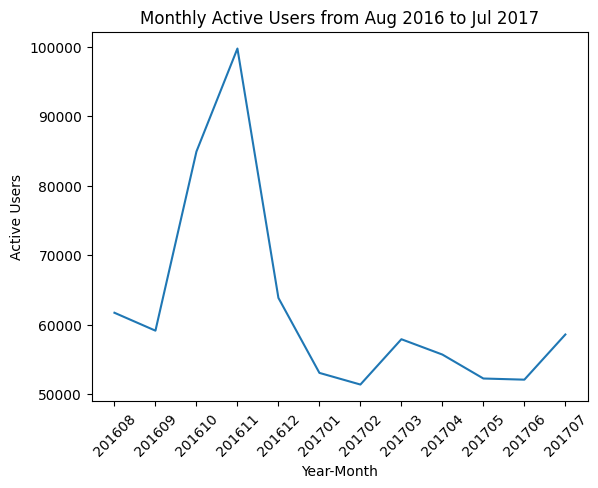

In [ ]:
query = """
SELECT 
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    COUNT(DISTINCT fullVisitorId) AS active_users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    year_month
ORDER BY 
    year_month
"""
result = client.query(query).result().to_dataframe()

# 데이터프레임을 이용한 lineplot 생성
sns.lineplot(data=result, x='year_month', y='active_users')
plt.xticks(rotation=45) # x축 라벨 회전
plt.title('Monthly Active Users from Aug 2016 to Jul 2017')
plt.xlabel('Year-Month')
plt.ylabel('Active Users')
plt.show()

In [ ]:
result['active_users'].mean()

62511.416666666664

201609 ~ 201612에 무슨 일이 있었던 거지?

- 신규 유저가 증가했나?

- 리텐션이 좋아졌나?

## 2) NAU 분석 

MAU를 신규 유저와 기존 유저로 쪼개서 확인해보자

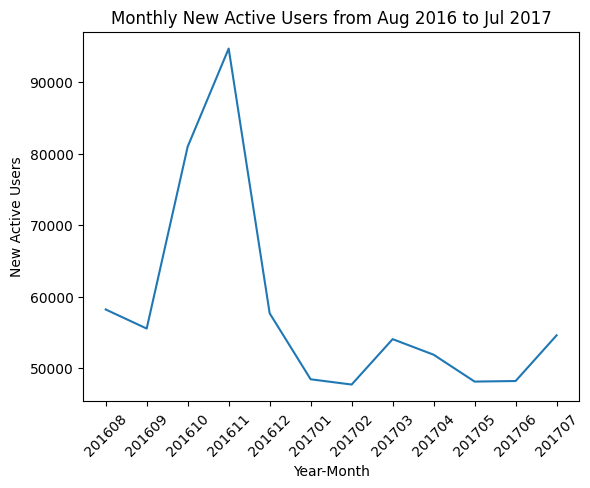

In [ ]:
# 월별 NAU 확인
query = """
SELECT 
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    COUNT(DISTINCT fullVisitorId) AS new_users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    AND totals.newVisits = 1
GROUP BY 
    year_month
ORDER BY 
    year_month
"""

result = client.query(query).result().to_dataframe()
# Bar plot 생성
sns.lineplot(data=result, x='year_month', y='new_users')
plt.xticks(rotation=45) # x축 라벨 회전
plt.title('Monthly New Active Users from Aug 2016 to Jul 2017')
plt.xlabel('Year-Month')
plt.ylabel('New Active Users')
plt.show()


In [ ]:
result['new_users'].mean()

58361.75

신규 유저의 증가가 mau 증가에도 영향을 미쳤다는 걸 확인할 수 있다. 다만 왜?

신규 유저들이 어느 페이지를 방문했는지 확인해보자 

1. 201610

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\2665314939.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




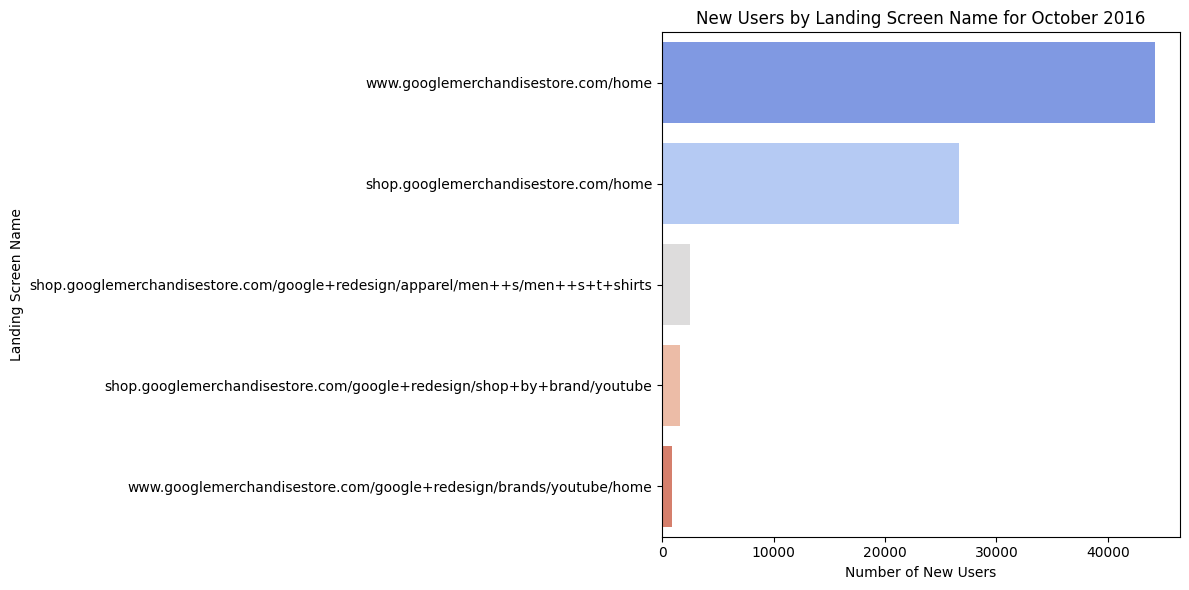

In [ ]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201610*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for October 2016')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


2. 201611

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\1261939657.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




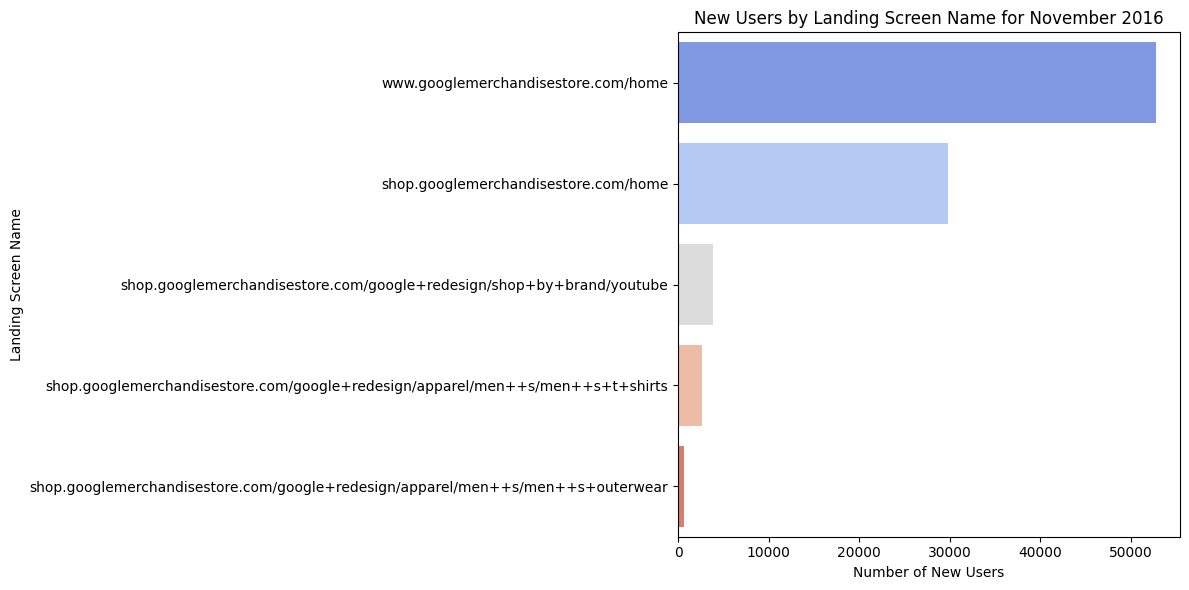

In [ ]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for November 2016')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


3. 전체 기간 

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\1901750125.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




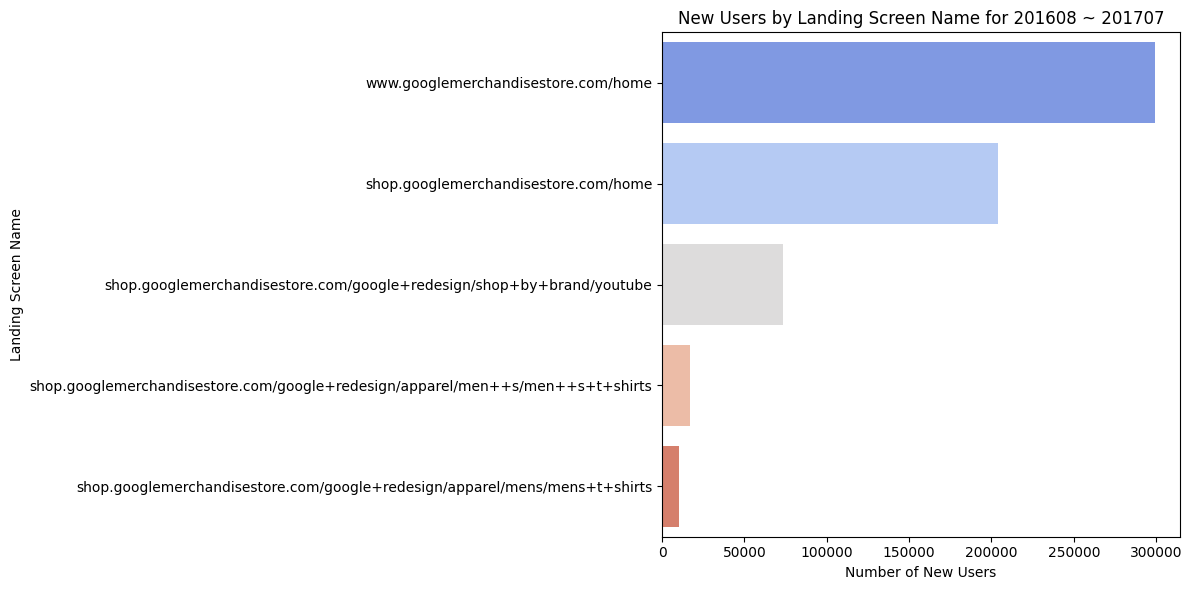

In [ ]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for 201608 ~ 201707')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


## 5) Stickiness 분석 

#### DAU/MAU 비율을 통해 stickiness 측정

사용자들이 사이트에 얼마나 자주 돌아오는지 확인 가능


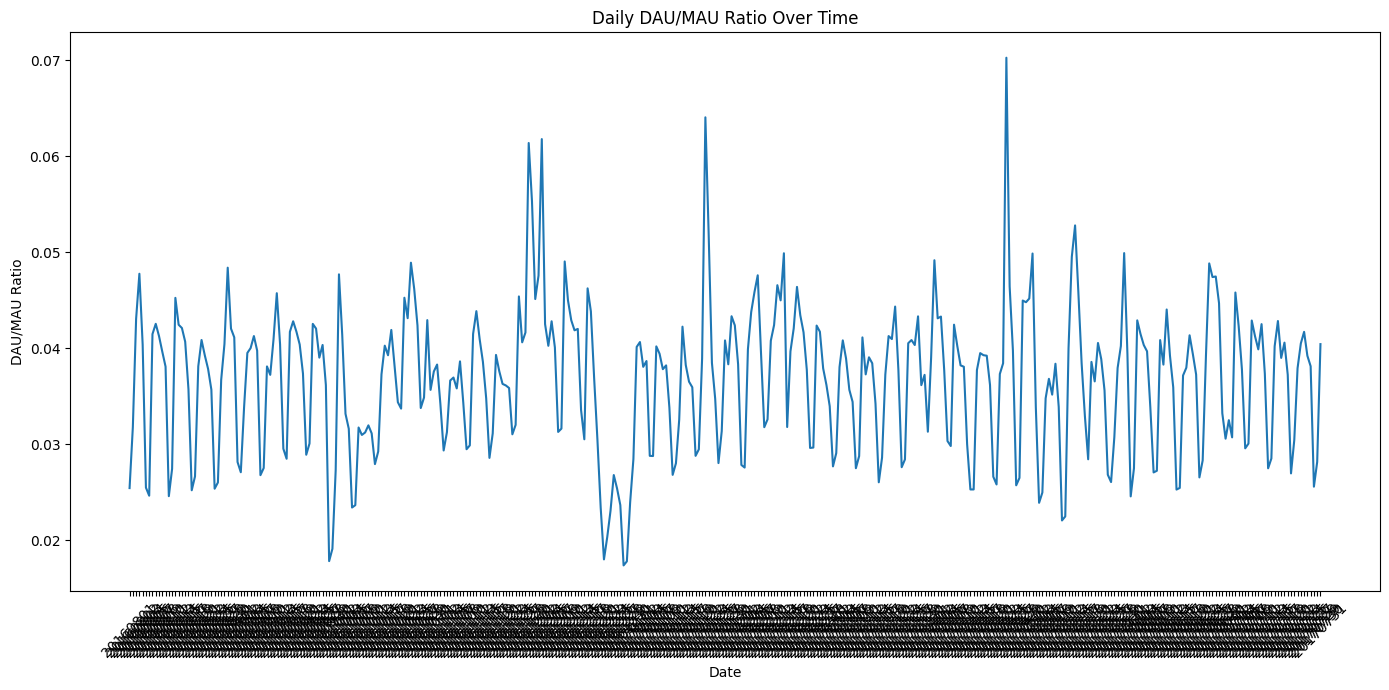

In [ ]:
query = """
WITH daily_active_users AS (
    SELECT 
        FORMAT_DATE('%Y%m%d', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS date,
        COUNT(DISTINCT fullVisitorId) AS dau
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    GROUP BY 
        date
),
monthly_active_users AS (
    SELECT 
        FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
        COUNT(DISTINCT fullVisitorId) AS mau
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    GROUP BY 
        year_month
),
dau_mau_ratio AS (
    SELECT 
        dau.date,
        dau.dau,
        mau.mau,
        (dau.dau / mau.mau) AS dau_mau_ratio
    FROM 
        daily_active_users dau
    JOIN 
        monthly_active_users mau ON FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', dau.date)) = mau.year_month
)
SELECT 
    *
FROM 
    dau_mau_ratio
ORDER BY 
    date
"""

dau_mau_df = client.query(query).result().to_dataframe()



# DAU/MAU 비율의 시간에 따른 변화를 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=dau_mau_df, x='date', y='dau_mau_ratio')

plt.title('Daily DAU/MAU Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('DAU/MAU Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


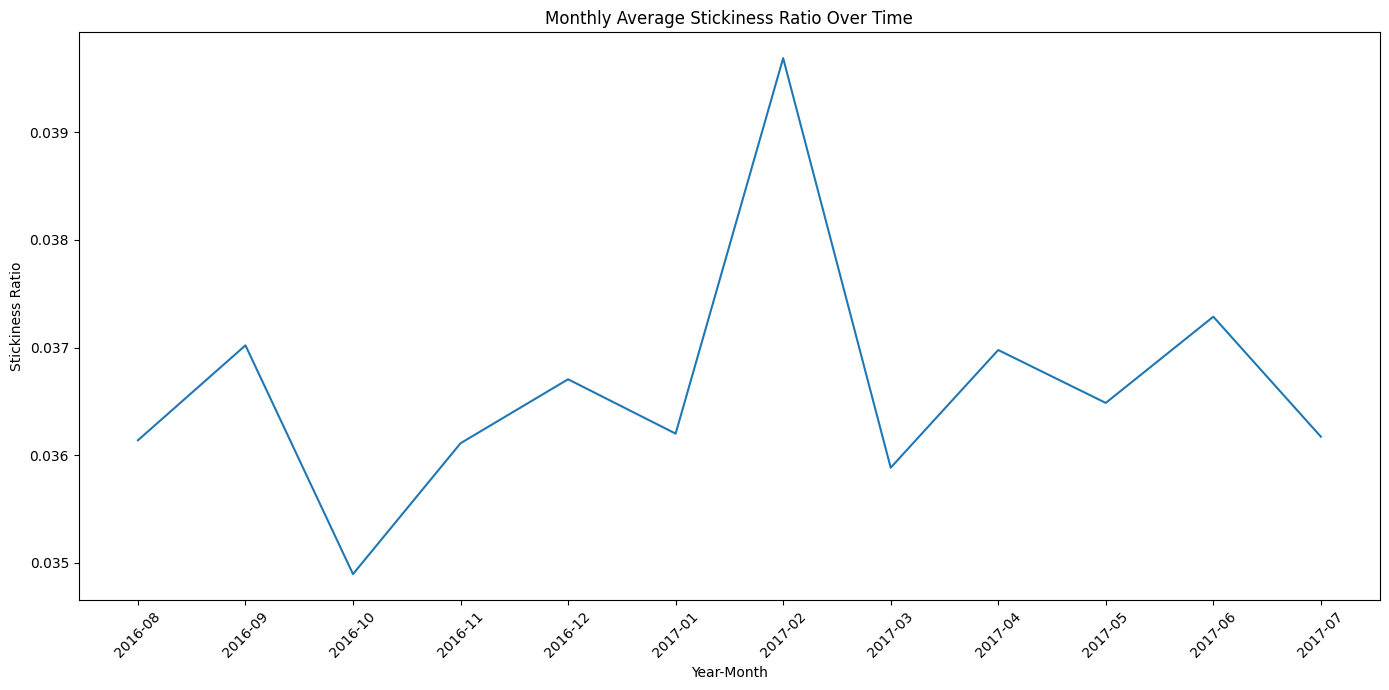

In [ ]:
# 'date' 열을 datetime 타입으로 변환
dau_mau_df['date'] = pd.to_datetime(dau_mau_df['date'])

# 연-월 정보만 추출하여 새로운 열 생성
dau_mau_df['year_month'] = dau_mau_df['date'].dt.strftime('%Y-%m')

# 연-월별 평균 DAU/MAU 비율 계산
monthly_dau_mau = dau_mau_df.groupby('year_month')['dau_mau_ratio'].mean().reset_index()

# 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_dau_mau, x='year_month', y='dau_mau_ratio')

plt.title('Monthly Average Stickiness Ratio Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Stickiness Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6) 방문 수와 페이지뷰 분석

방문 수와 페이지뷰: 사이트의 상황을 진단 가능

방문수: 웹사이트에 유입된 수 (= 세션 수)
페이지뷰: 웹사이트의 페이지가 열려진 횟수 (방문수와 같거나 큼)

ex 내가 웹사이트 방문해서 10개 페이지 열었다면 페이지 뷰 = 10, 방문 수 = 1


방문 수 증가하는데 페이지뷰 감소 가능 
방문 수 감소하는데 페이지뷰 증가 가능 

1. 방문 수 증가, 페이지뷰 증가 = 신규 방문 + 재방문 수 증가

방문당 페이지뷰: 특정 기간의 전체 페이지뷰 / 특정 기간의 방문 수 
-> 한 번 방문할 때 얼마나 많은 페이지를 열어보는지에 대한 평균값 

2. 방문 수 증가, 페이지뷰 감소 = 신규 방문은 늘었으나 붙잡아 두기 힘듦

3. 방문 수 감소, 페이지뷰 증가 = 커뮤니티 등

4. 방문수 감소, 페이지뷰 감소 = 원인은 여러 가지
1) 유입 채널 축소 2) 검색 엔진 및 검색 광고의 경쟁 심화 3) (재방문의 경우) 사이트 신뢰도 4) 부족한 콘텐츠(상품) 5) 느린 업데이트 6) 가격 경쟁력 저하 

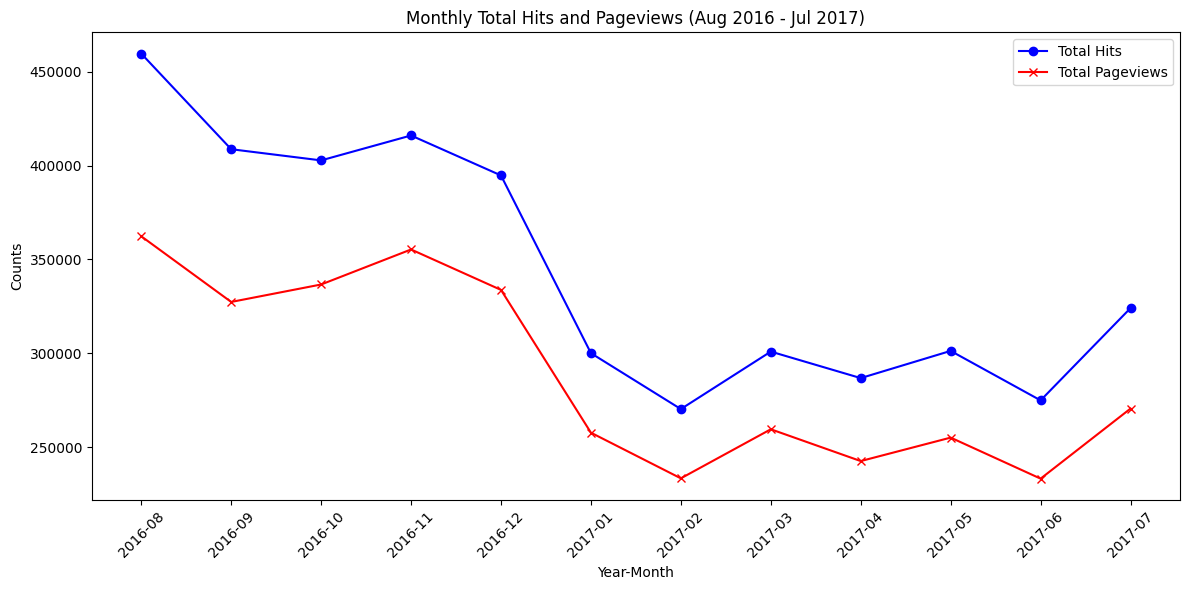

In [ ]:
# totals.hits: 세션 내의 총 조회수 (이건 방문 수가 아닌 것 같은데..)
# totals.pageviews: 세션 내의 총 페이지뷰 수

query = """
SELECT
    FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    SUM(totals.hits) AS total_hits,
    SUM(totals.pageviews) AS total_pageviews
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
    year_month
ORDER BY
    year_month
"""

# 쿼리 실행
query_result = client.query(query).result().to_dataframe()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(query_result['year_month'], query_result['total_hits'], label='Total Hits', color='blue', marker='o')
plt.plot(query_result['year_month'], query_result['total_pageviews'], label='Total Pageviews', color='red', marker='x')

plt.title('Monthly Total Hits and Pageviews (Aug 2016 - Jul 2017)')
plt.xlabel('Year-Month')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

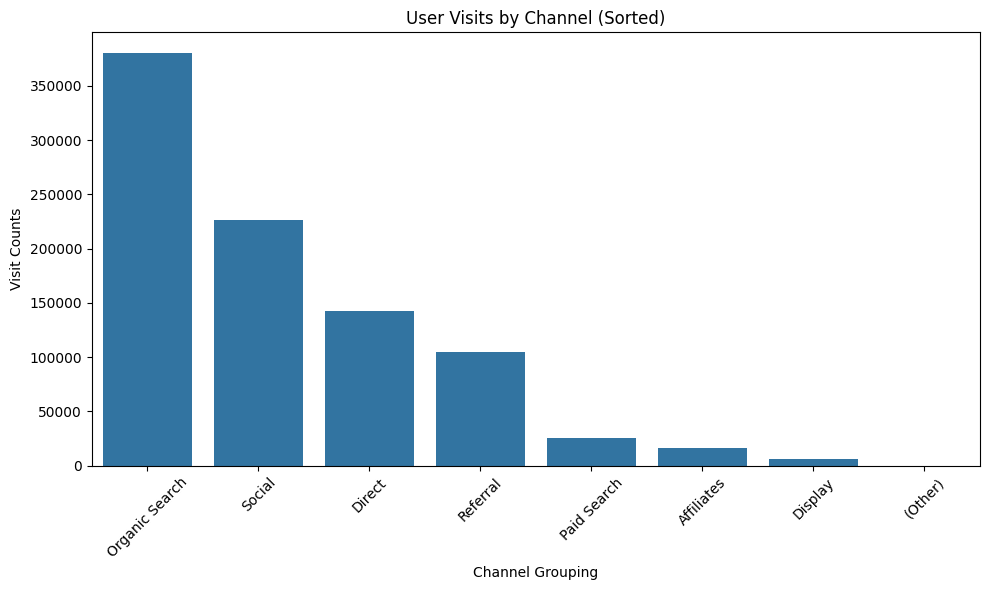

In [ ]:
# 유입 채널에 따른 사용자 시각화 
# channelGrouping: 이 보기의 최종 사용자 세션과 연결된 기본 채널 그룹 (뭔 소리지)

query = """
SELECT
    channelGrouping, COUNT(channelGrouping) as cg_num
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
    channelGrouping
"""

query_result = client.query(query).result().to_dataframe()
query_result_sorted = query_result.sort_values('cg_num', ascending=False)



# 채널별 방문 횟수 막대 그래프를 그립니다.
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

sns.barplot(data=query_result_sorted, x='channelGrouping', y='cg_num')

plt.title('User Visits by Channel (Sorted)')  # 그래프 제목
plt.xlabel('Channel Grouping')  # x축 라벨
plt.ylabel('Visit Counts')  # y축 라벨
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시b

## 7) UTM 분석

UTM 파라미터 분석을 통해 채널별 성과 측정을 할 수 있음. 

* 광고 
* 소스
* 캠페인
* 매체
 

### 광고

In [ ]:
# trafficSource.adContent: 트래픽 소스의 광고 콘텐츠
# utm_content URL 매개변수로 설정 가능 

query = """
SELECT
  trafficSource.adContent AS AdContent,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.adContent IS NOT NULL
GROUP BY
  AdContent, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

ad_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\3257153874.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




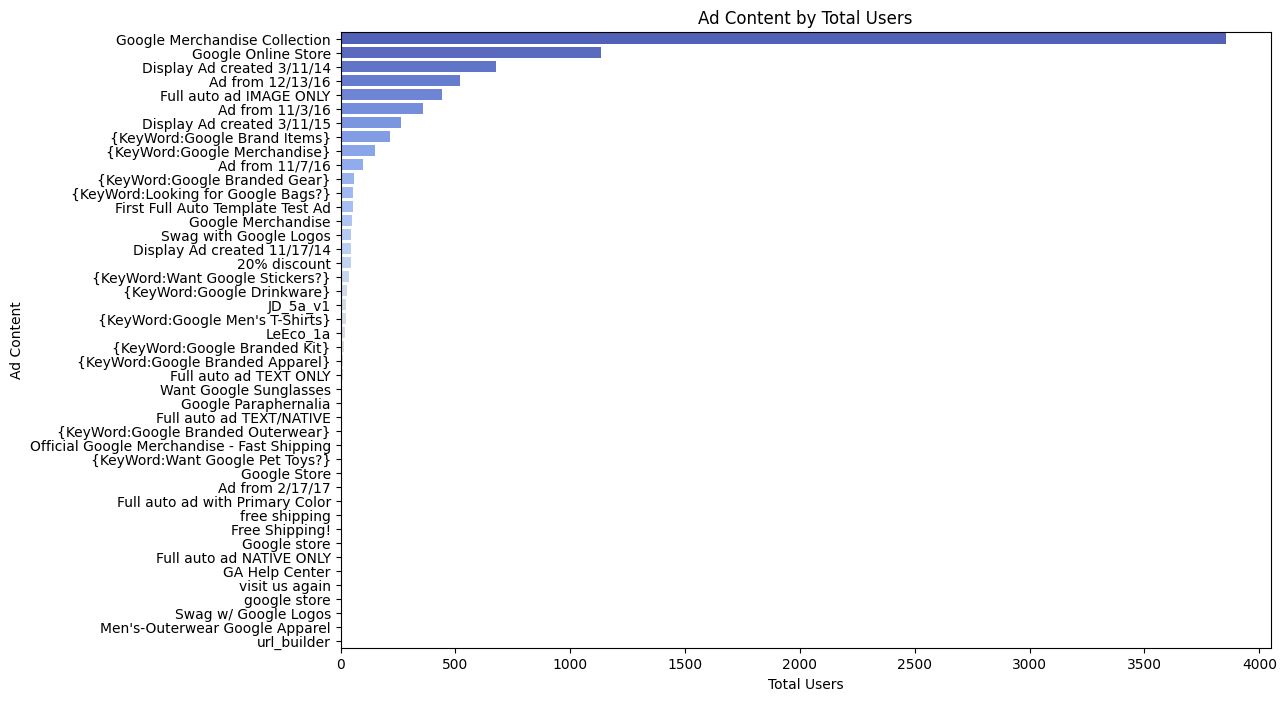

In [ ]:
# 광고 콘텐츠별 총 사용자 수를 계산
df_grouped = ad_utm.groupby('AdContent')['Users'].sum().reset_index()

# 광고 콘텐츠별 총 사용자 수를 기준으로 내림차순 정렬
df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='AdContent', palette='coolwarm')
plt.title('Ad Content by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Ad Content')
plt.show()

다른 값들이 너무 안 보이니까 google merchandise collection은 제외하고 시각화해보자 

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\3080296782.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




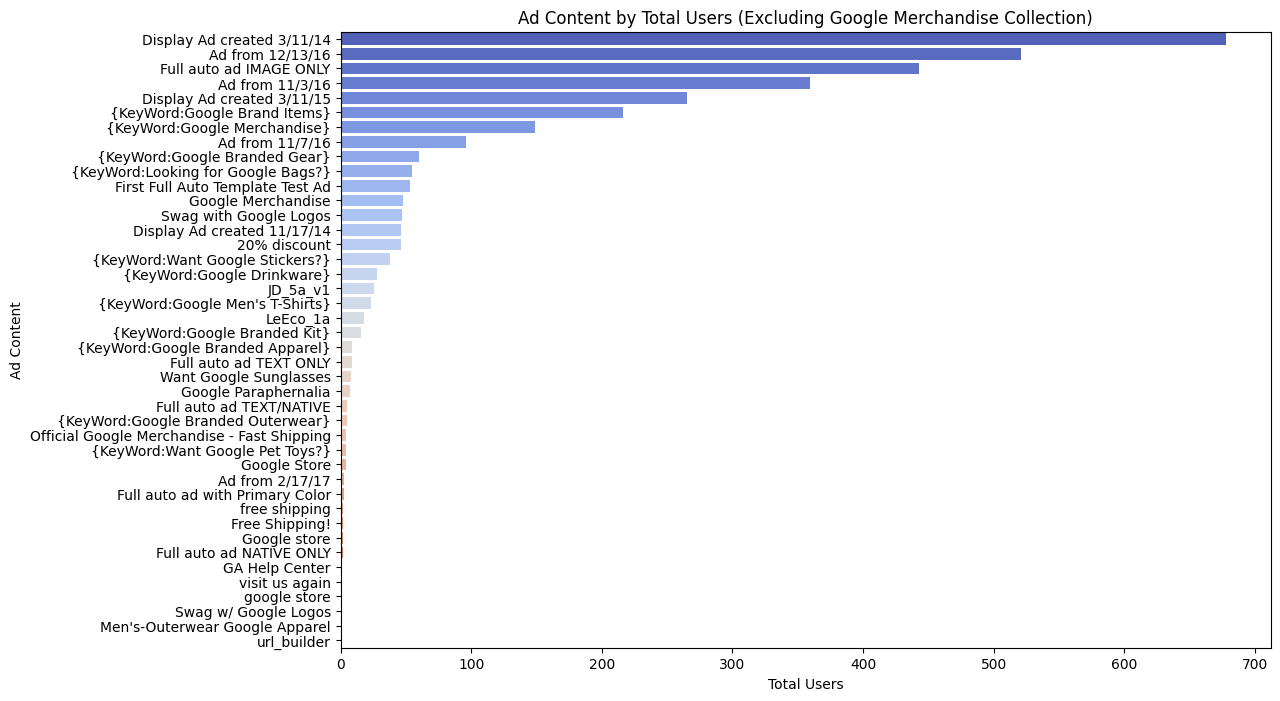

In [ ]:
# google merchandise collection 제외 시각화

df_filtered = df_grouped_sorted[df_grouped_sorted['AdContent'] != 'Google Merchandise Collection']
df_filtered = df_filtered[df_filtered['AdContent'] != 'Google Online Store']

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_filtered, x='Users', y='AdContent', palette='coolwarm')
plt.title('Ad Content by Total Users (Excluding Google Merchandise Collection)')
plt.xlabel('Total Users')
plt.ylabel('Ad Content')
plt.show()

### 캠페인

In [ ]:
# trafficSource.campaign: 캠페인의 가치
# 보통 utm_campaign URL 매개변수로 설정


query = """
SELECT
  trafficSource.campaign AS Campaign,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.campaign IS NOT NULL
GROUP BY
  Campaign, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

cam_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\1384165768.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




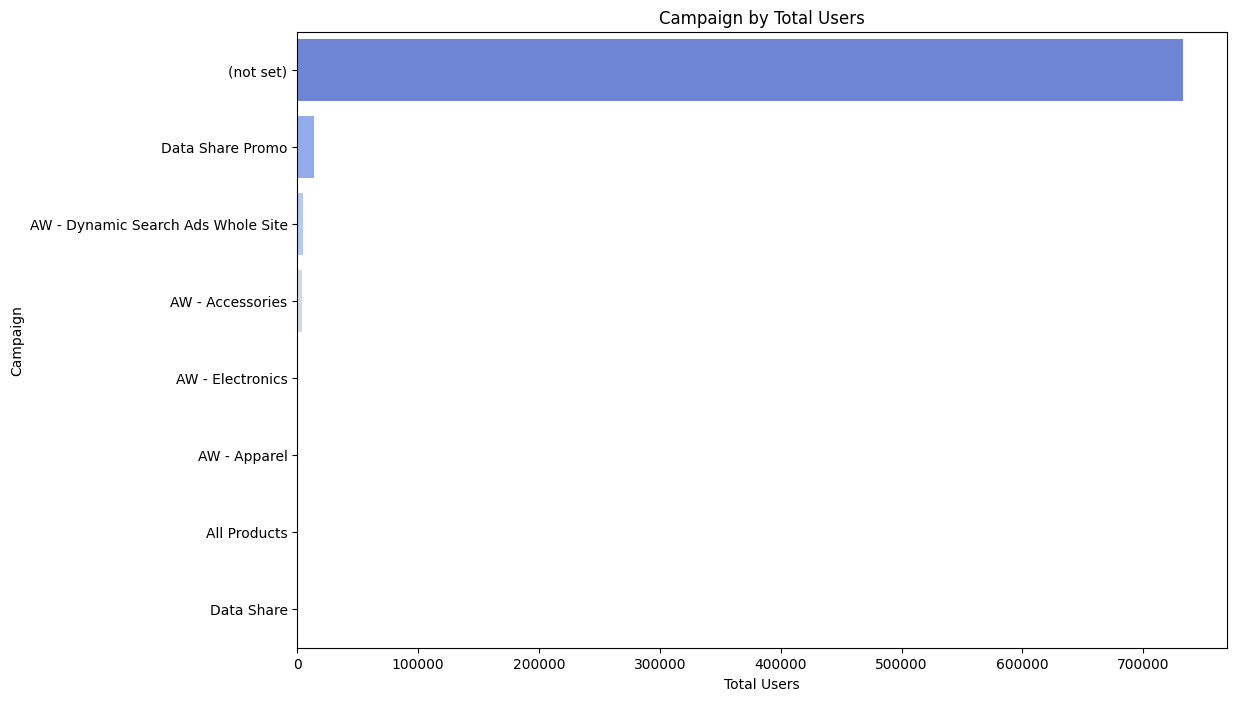

In [ ]:
df_grouped = cam_utm.groupby('Campaign')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='Campaign', palette='coolwarm')
plt.title('Campaign by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Campaign')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\69039399.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




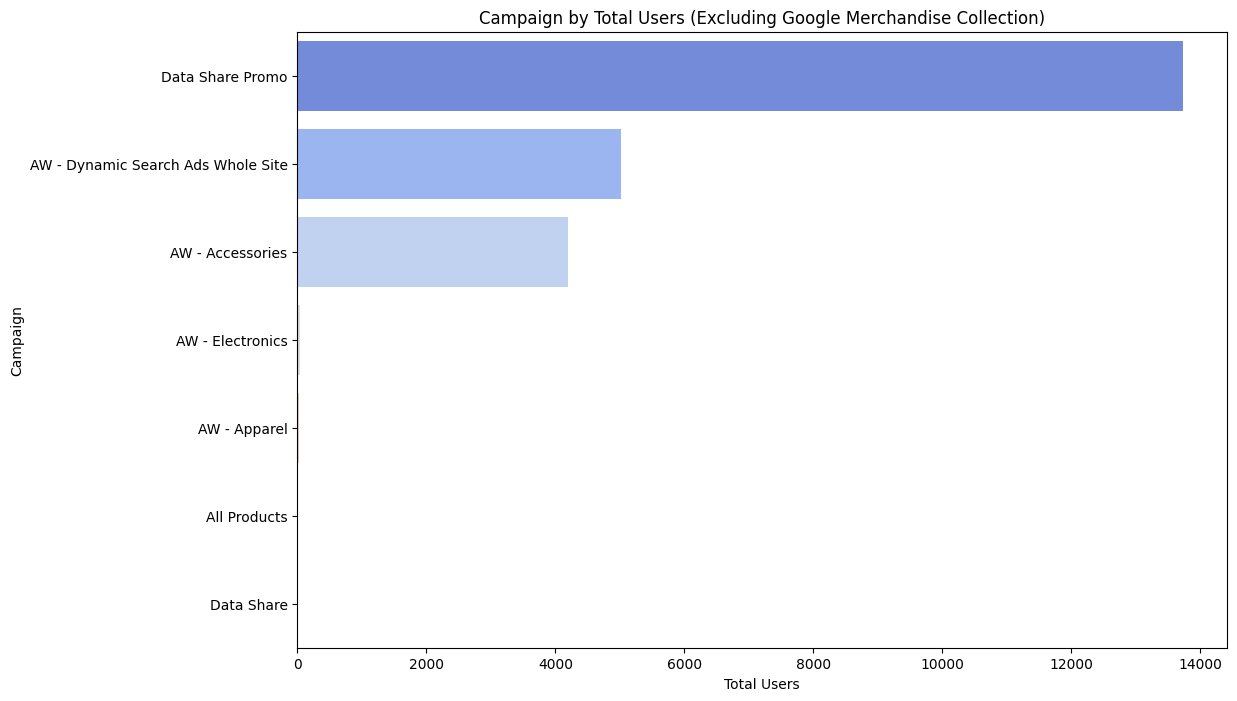

In [ ]:
# not set 제외
df_filtered = df_grouped_sorted[df_grouped_sorted['Campaign'] != '(not set)']

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_filtered, x='Users', y='Campaign', palette='coolwarm')
plt.title('Campaign by Total Users (Excluding Google Merchandise Collection)')
plt.xlabel('Total Users')
plt.ylabel('Campaign')
plt.show()


### medium

In [ ]:
# trafficSource.medium: 트래픽 소스의 매체

query = """
SELECT
  trafficSource.medium AS Medium,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.medium IS NOT NULL
GROUP BY
  Medium, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

med_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\3299673054.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




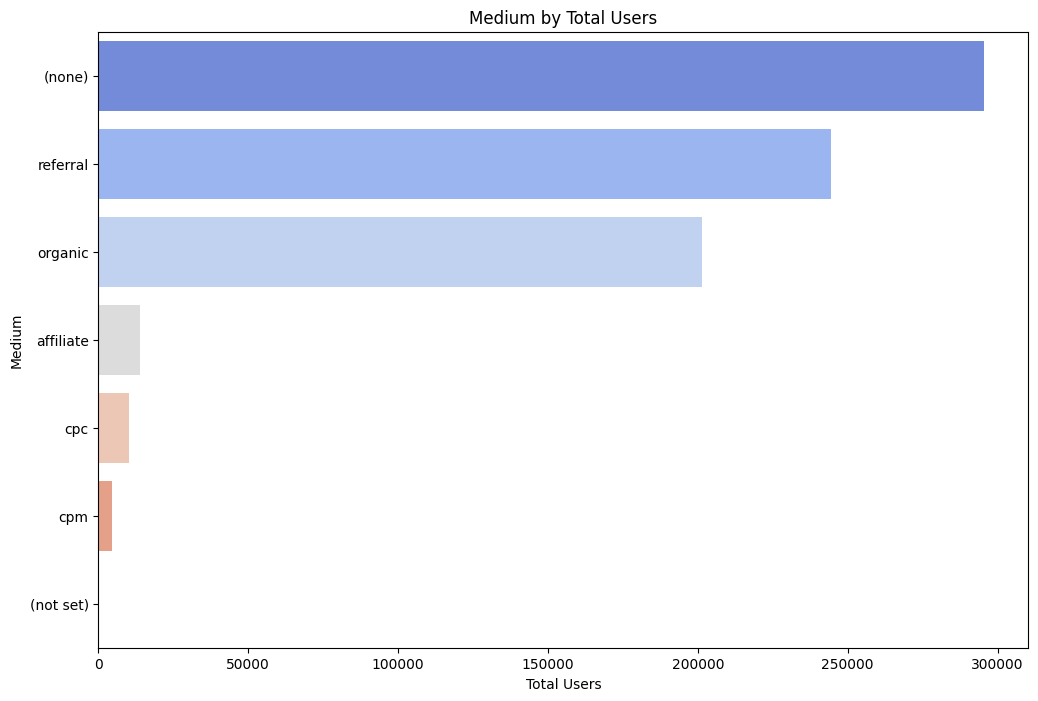

In [ ]:
df_grouped = med_utm.groupby('Medium')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='Medium', palette='coolwarm')
plt.title('Medium by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Medium')
plt.show()

### source

In [ ]:
# trafficSource.source: 트래픽 소스의 소스	

query = """
SELECT
  trafficSource.source AS Source,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.source IS NOT NULL
GROUP BY
  Source, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

sor_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8232\3967742739.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




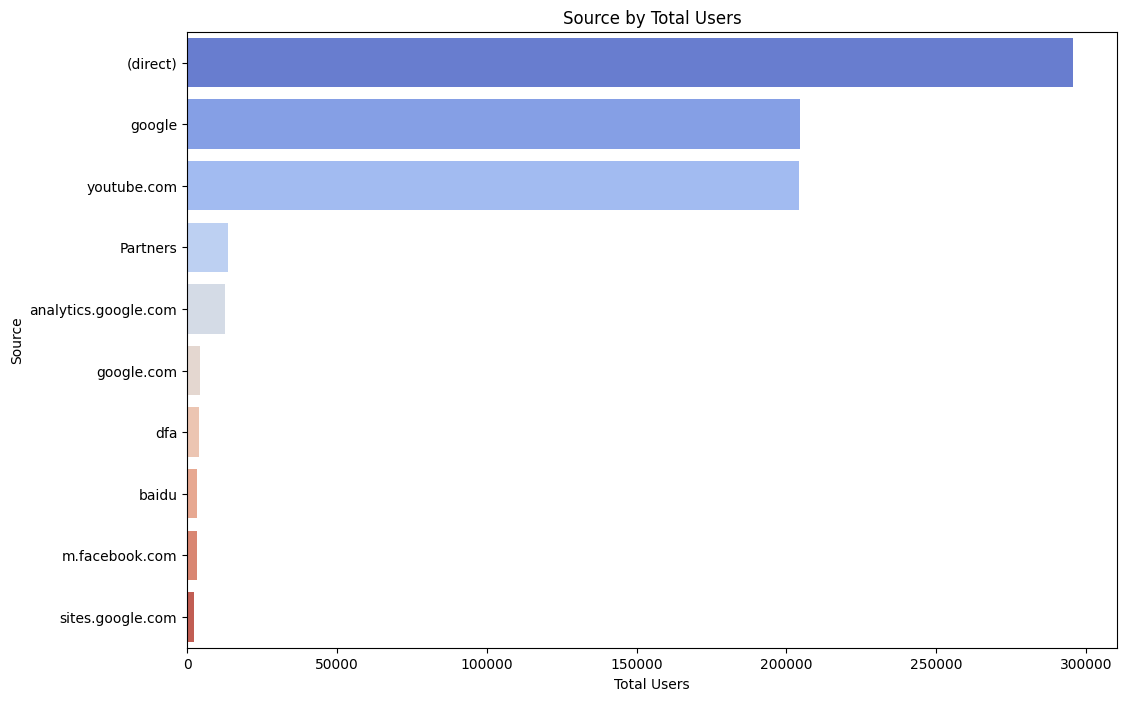

In [ ]:
df_grouped = sor_utm.groupby('Source')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

top_ad_contents = df_grouped_sorted.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_ad_contents, x='Users', y='Source', palette='coolwarm')
plt.title('Source by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Source')
plt.show()